## Milestone 2
In this exercise, we will explore the House Sales dataset in King County using various statistical analysis and hypothesis testing techniques.

We will:
1. Explore dataset using charts and summary statistics
2. Identify a likely distribution for several of the features
3. Compute basic summary statistics by classical, bootstrap and Bayesian methods
4. Compute confidence intervals for the above summary statistics by classical, bootstrap and Bayesian methods
5. Leverage confidence intervals in performing hypothesis tests to determina if the differences in pairs and multiple populations are significant

For this exercise, we will only look at properties with:
- Sales price less than $2M
- Lot size less than 100,000 sq ft 
- 1-6 bedrooms

#### Import python packages & load data set
Importing necessary packages and loading the King County House Sales data set data set from the UW library (https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import scipy
import scipy.stats as ss
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.stats.weightstats as ws
import statsmodels.stats.power as smsp
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline

url = 'https://library.startlearninglabs.uw.edu/DATASCI410/Datasets/kc_house_data.csv'
df = pd.read_csv(url)

#df['date'] = pd.to_datetime(df['date'].str[0:8])
#df['month'] = df['date'].values.astype('datetime64[M]')
df['year'] = pd.DatetimeIndex(df['date']).year

df.where(df['price']<=2000000, inplace= True)
df.where(((df['bedrooms']<=6)&(df['bedrooms']>=1)), inplace=True)
df.where(df['sqft_lot']<=100000, inplace= True)
df.where(df['grade']>0, inplace= True)

df.dropna(inplace=True)

df.drop(['id', 'date', 'lat', 'long'], axis=1, inplace=True)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,year
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,1180.0,0.0,1955.0,0.0,98178.0,1340.0,5650.0,2014.0
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,2170.0,400.0,1951.0,1991.0,98125.0,1690.0,7639.0,2014.0
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,770.0,0.0,1933.0,0.0,98028.0,2720.0,8062.0,2015.0
3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,1050.0,910.0,1965.0,0.0,98136.0,1360.0,5000.0,2014.0
4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,1680.0,0.0,1987.0,0.0,98074.0,1800.0,7503.0,2015.0


In [2]:
print('\nData types\n', df.dtypes)

print('\nCheck for missing value\n', df.isnull().any())

print('\nDataset shape: ', df.shape)


Data types
 price            float64
bedrooms         float64
bathrooms        float64
sqft_living      float64
sqft_lot         float64
floors           float64
waterfront       float64
view             float64
condition        float64
grade            float64
sqft_above       float64
sqft_basement    float64
yr_built         float64
yr_renovated     float64
zipcode          float64
sqft_living15    float64
sqft_lot15       float64
year             float64
dtype: object

Check for missing value
 price            False
bedrooms         False
bathrooms        False
sqft_living      False
sqft_lot         False
floors           False
waterfront       False
view             False
condition        False
grade            False
sqft_above       False
sqft_basement    False
yr_built         False
yr_renovated     False
zipcode          False
sqft_living15    False
sqft_lot15       False
year             False
dtype: bool

Dataset shape:  (20885, 18)


#### Data Transformation: Calculations & Binnings
Here, we're calculating the age of the house and the age of the house renovation, if the house has been renovated. We're also binning the bathrooms as well as the size (square footage) variables to simplify the data for analysis.

In [3]:
#calculate house age & renovation age when sold
df['age'] = df['year'] - df['yr_built'] + 1
df.loc[df['age'] <= 0, 'age'] = 1

#df['rnv_age'] = df.loc[df['yr_renovated']!=0, 'year'] - df.loc[df['yr_renovated']!=0, 'yr_renovated']
#df.loc[df['yr_renovated']==0, 'rnv_age'] = 0
#df.loc[df['rnv_age'] <= 0, 'rnv_age'] = 0


df.loc[df['yr_renovated']==0, 'renovated'] = 1
df.loc[df['yr_renovated']>0, 'renovated'] = 0

df.loc[df['sqft_basement']==0, 'basement'] = 1
df.loc[df['sqft_basement']>0, 'basement'] = 0

#binning: bathroom
nbins = [-1, 1, 2, 3, 4, 5, 6, 10]
nlabels = ['<=1','1.25-2', '2.25-3', '3.25-4', '4.25-5', '5.25-6', '6+']

df.loc[:, 'bathrooms_bin'] = pd.cut(df.loc[:, 'bathrooms'], bins = nbins, labels = nlabels)


#binning: age
nbins = [-1, 10, 20, 30, 40, 50, 60, 70, 80, 300]
nlabels = ['<=10','11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80']

df.loc[:, 'age_bin'] = pd.cut(df.loc[:, 'age'], bins = nbins, labels = nlabels)


#binning: grade
nbins = [-1, 3, 6, 9, 13]
nlabels = ['1-3','4-6', '7-9', '>9']

df.loc[:, 'grade_bin'] = pd.cut(df.loc[:, 'grade'], bins = nbins, labels = nlabels)


#binning: sqft_living, sqft_lot, sqft_above, sqft_basement, sqft_living15, sqft_lot15
nbins = [-1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 2000000]
nlabels = ['<1000','1001-2000','2001-3000','3001-4000','4001-5000','5001-6000','6001-7000','7001-8000','8001-9000','9001-10000','>10000']

df.loc[:, 'sqft_lot_bin'] = pd.cut(df.loc[:, 'sqft_lot'], bins = nbins, labels = nlabels)
#df.loc[:, 'sqft_lot15_bin'] = pd.cut(df.loc[:, 'sqft_lot15'], bins = nbins, labels = nlabels)


nbins = [-1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000]
nlabels = ['<1000','1001-2000','2001-3000','3001-4000','4001-5000','5001-6000','6001-7000','7001-8000']

df.loc[:, 'sqft_living_bin'] = pd.cut(df.loc[:, 'sqft_living'], bins = nbins, labels = nlabels)


#nbins = [-1, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000]
#nlabels = ['<1000','1001-2000','2001-3000','3001-4000','4001-5000','5001-6000','6001-7000','7001-8000','8001-9000','9001-10000']

#df.loc[:, 'sqft_above_bin'] = pd.cut(df.loc[:, 'sqft_above'], bins = nbins, labels = nlabels)


#nbins = [-1, 1000, 2000, 3000, 4000, 5000]
#nlabels = ['<1000','1001-2000','2001-3000','3001-4000','4001-5000']

#df.loc[:, 'sqft_basement_bin'] = pd.cut(df.loc[:, 'sqft_basement'], bins = nbins, labels = nlabels)

nbins = [-1, 1000, 2000, 3000, 4000, 5000, 6000]
nlabels = ['<1000','1001-2000','2001-3000','3001-4000','4001-5000','5001-6000']

#df.loc[:, 'sqft_living15_bin'] = pd.cut(df.loc[:, 'sqft_living15'], bins = nbins, labels = nlabels)

df.drop(['year', 'sqft_above', 'sqft_basement'], axis=1, inplace=True)

df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_living15,sqft_lot15,age,renovated,basement,bathrooms_bin,age_bin,grade_bin,sqft_lot_bin,sqft_living_bin
0,221900.0,3.0,1.00,1180.0,5650.0,1.0,0.0,0.0,3.0,7.0,...,1340.0,5650.0,60.0,1.0,1.0,<=1,51-60,7-9,5001-6000,1001-2000
1,538000.0,3.0,2.25,2570.0,7242.0,2.0,0.0,0.0,3.0,7.0,...,1690.0,7639.0,64.0,0.0,0.0,2.25-3,61-70,7-9,7001-8000,2001-3000
2,180000.0,2.0,1.00,770.0,10000.0,1.0,0.0,0.0,3.0,6.0,...,2720.0,8062.0,83.0,1.0,1.0,<=1,>80,4-6,9001-10000,<1000
3,604000.0,4.0,3.00,1960.0,5000.0,1.0,0.0,0.0,5.0,7.0,...,1360.0,5000.0,50.0,1.0,0.0,2.25-3,41-50,7-9,4001-5000,1001-2000
4,510000.0,3.0,2.00,1680.0,8080.0,1.0,0.0,0.0,3.0,8.0,...,1800.0,7503.0,29.0,1.0,1.0,1.25-2,21-30,7-9,8001-9000,1001-2000


#### Explore dataset supported by charts and summary statistics

In [4]:
print('Dataset Summary Statistics')
print(df.describe())

Dataset Summary Statistics
              price      bedrooms     bathrooms   sqft_living      sqft_lot  \
count  2.088500e+04  20885.000000  20885.000000  20885.000000  20885.000000   
mean   5.156891e+05      3.350251      2.087551   2031.391956  10259.662677   
std    2.853387e+05      0.871535      0.736703    841.320956  11288.640998   
min    7.500000e+04      1.000000      0.000000    370.000000    520.000000   
25%    3.199000e+05      3.000000      1.500000   1410.000000   5000.000000   
50%    4.457000e+05      3.000000      2.250000   1890.000000   7500.000000   
75%    6.300000e+05      4.000000      2.500000   2500.000000  10230.000000   
max    2.000000e+06      6.000000      6.500000   7620.000000  99916.000000   

             floors    waterfront          view     condition         grade  \
count  20885.000000  20885.000000  20885.000000  20885.000000  20885.000000   
mean       1.488652      0.005458      0.212784      3.410965      7.613933   
std        0.540157     

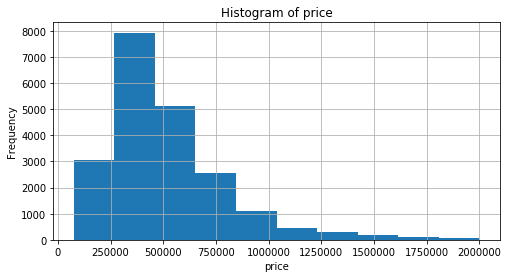

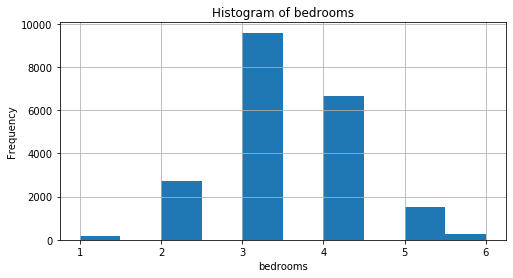

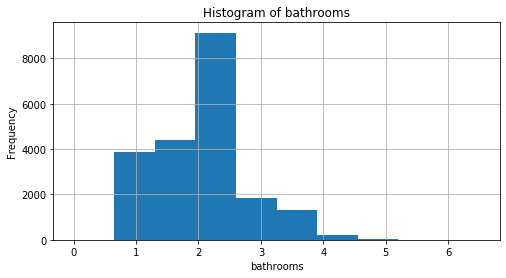

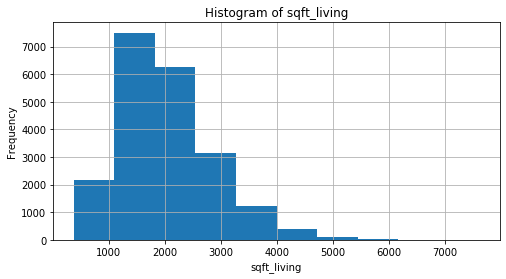

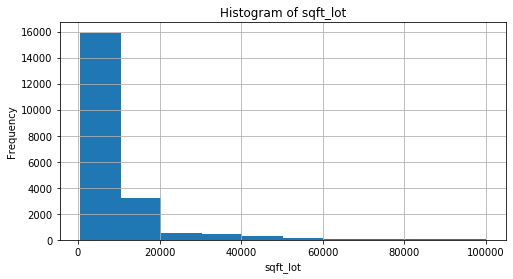

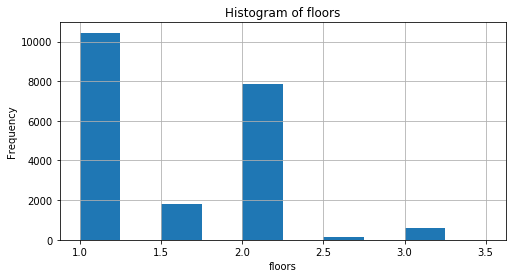

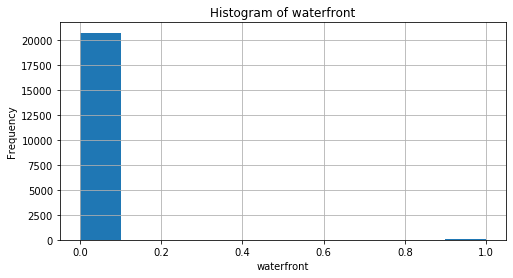

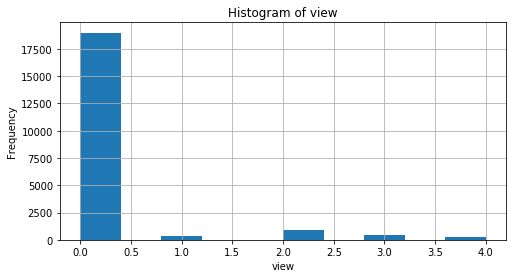

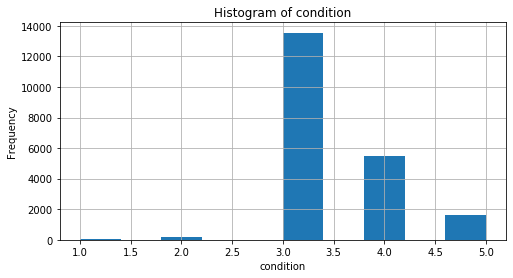

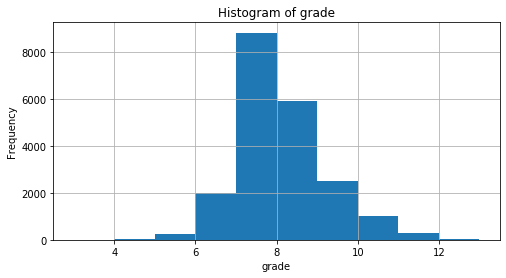

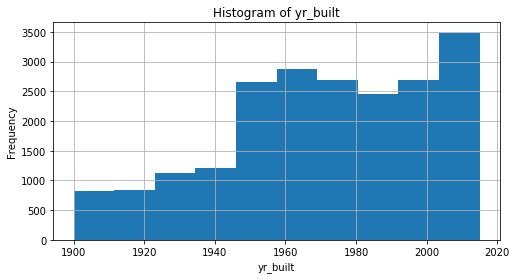

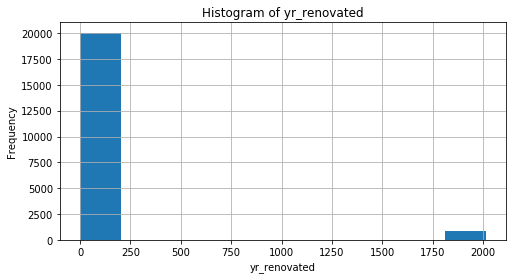

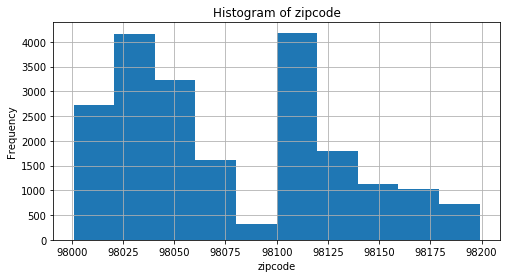

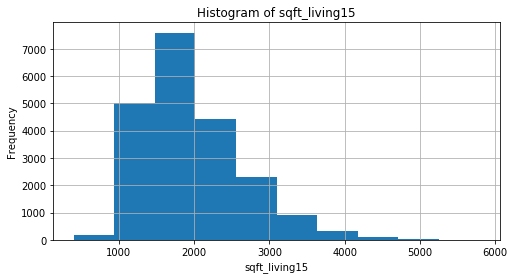

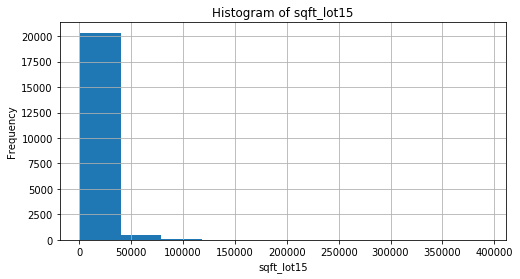

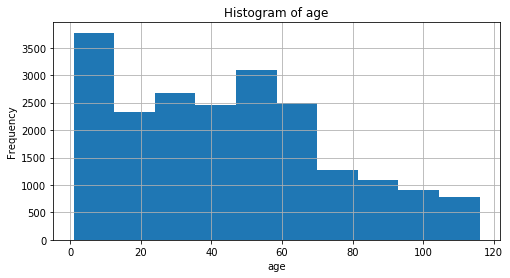

In [5]:
collist = df.drop(['renovated', 'basement', 'bathrooms_bin', 'age_bin', 'grade_bin', 'sqft_living_bin', 'sqft_lot_bin'], axis=1)

for col in collist:
    fig = plt.figure(figsize=(8, 4))
    ax = fig.gca()
    
    df[col].hist()
    ax.set_title('Histogram of '+ col)
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    plt.show()

#### Identify a likely distribution for several of the features

We're going to focus on the following features: Price, Bedrooms, Grades and Age

Based on the histograms above, we observe that these features are slightly skewed. When we take the Log value of these features, we see a closer to normal distribution. We check this using Distribution & QQ plot below.

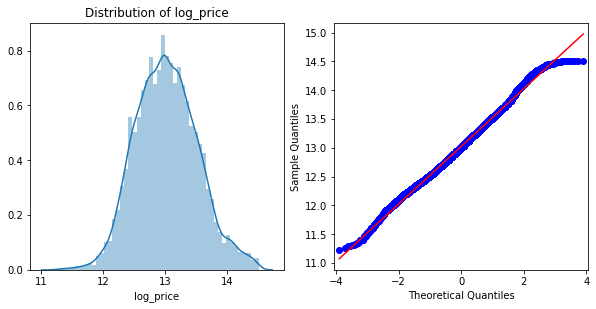

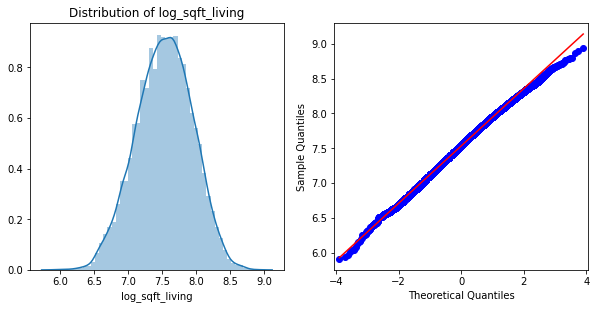

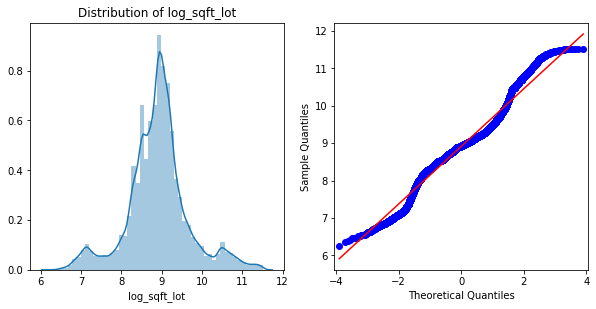

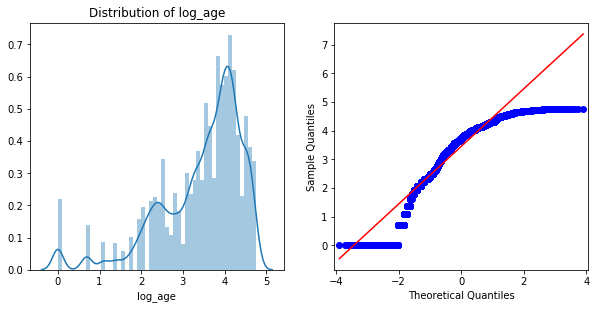

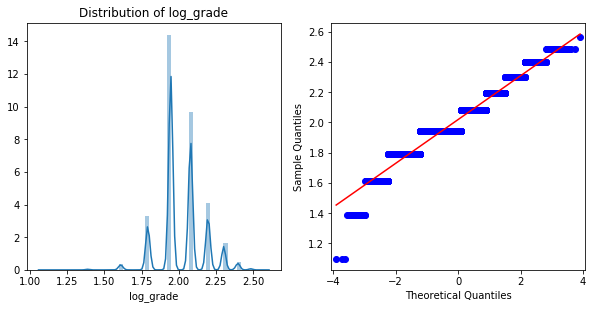

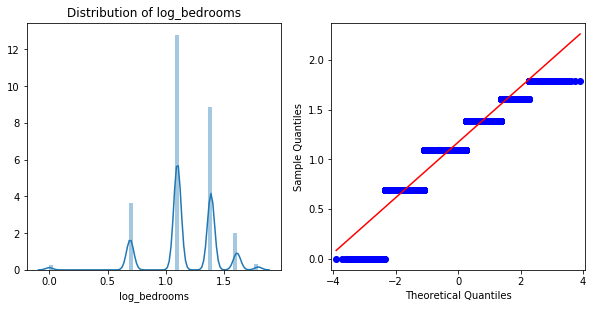

In [6]:
df['log_price'] = np.log(df['price'])
df['log_bedrooms'] = np.log(df['bedrooms'])
df['log_sqft_living'] = np.log(df['sqft_living'])
df['log_sqft_lot'] = np.log(df['sqft_lot'])
df['log_grade'] = np.log(df['grade'])
df['log_age'] = np.log(df['age'])

df.dropna(inplace=True)

log_features = ['log_price', 'log_sqft_living', 'log_sqft_lot', 'log_age', 'log_grade', 'log_bedrooms']

#plotting log values
for f in log_features:
    plt.figure(figsize=(10, 10)).gca()
    
    ax1 = plt.subplot(221)
    sns.distplot(df[f], ax = ax1)
    plt.title('Distribution of ' + f)
    
    ax2 = plt.subplot(222)
    sm.qqplot(df[f], line='s', ax = ax2)
    plt.show()

Analyzing our distribution and QQ plots above, we notice that log price and log square footage (living & lot) features are approximately normal (albeit a little skewed). The age feature has a mixed dsitribution with several local peaks and is not normally distributed.

#### Compute basic summary statistics & confidence intervals by Classical, Bootstrap and Bayesian methods

In [7]:
#classical summary statistics (mean, std error & ci) for: bedrooms, grade_bin, age_bin

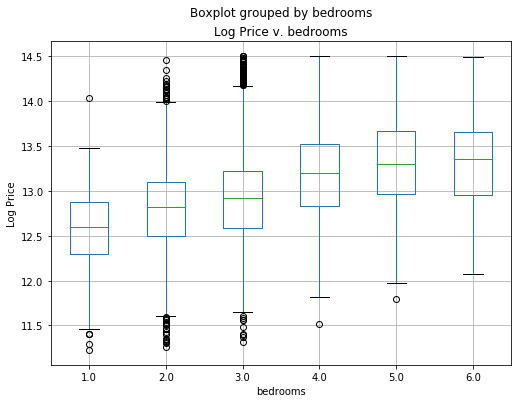

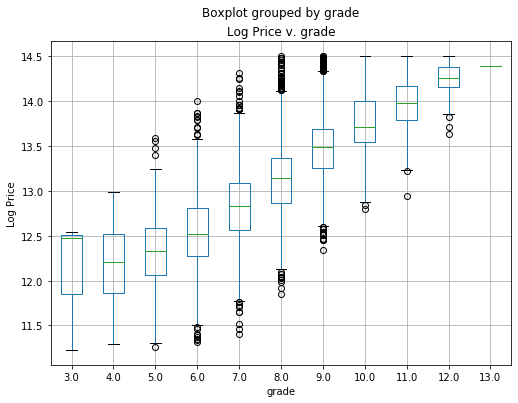

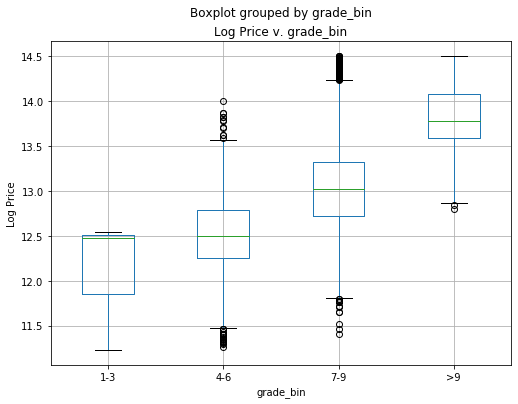

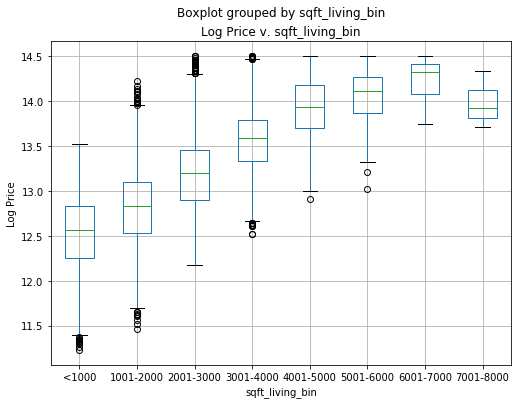

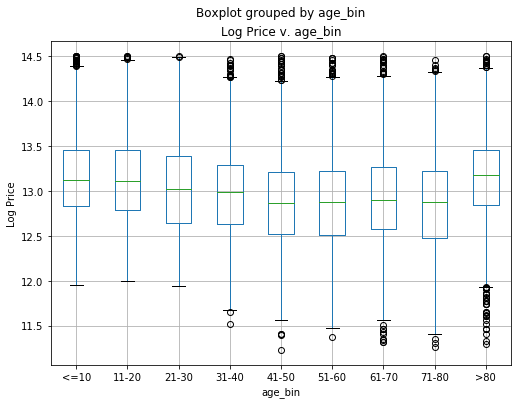

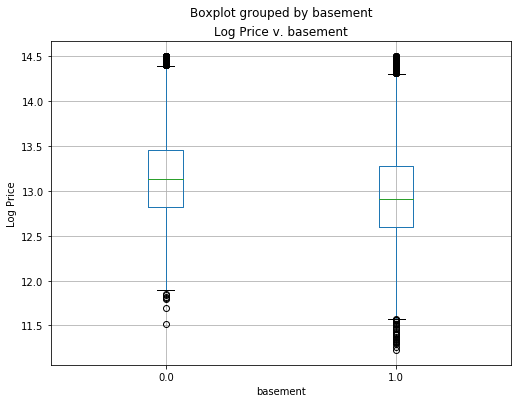

In [8]:
df2 = df[['log_price', 'bedrooms', 'grade', 'grade_bin', 'sqft_living_bin', 'age_bin', 'basement']]

for col in df2.drop('log_price', axis=1):
    fig = plt.figure(figsize=(8,6))
    ax = fig.gca()
    
    df.boxplot(column = ['log_price'], by = col, ax = ax)
    ax.set_title('Log Price v. '+ col)
    ax.set_xlabel(col)
    ax.set_ylabel('Log Price')
    plt.show()
    print('\n')

In [9]:
#classical summary statistics of log price by bedrooms

idx1 = ['mean', 'std_err', 'ci_lower', 'ci_upper']

bd = ['1bd', '2bd', '3bd', '4bd', '5bd', '6bd']

bd_sum_stats = pd.DataFrame(columns = bd, index=idx1)

for a in bd:
    bd_sum_stats.loc['mean'][a] = round(df2[df2['bedrooms']==int(a[0])]['log_price'].mean(),2)
    bd_sum_stats.loc['std_err'][a] = round(ss.sem(df2[df2['bedrooms']==int(a[0])]['log_price']),2)
    bd_sum_stats.loc['ci_lower'][a] = round(bd_sum_stats.loc['mean'][a] - 1.96 * bd_sum_stats.loc['std_err'][a],2)
    bd_sum_stats.loc['ci_upper'][a] = round(bd_sum_stats.loc['mean'][a] + 1.96 * bd_sum_stats.loc['std_err'][a],2)
    
print('Classical Summary Statistics for Log Price by Bedrooms - 95% CI')
bd_sum_stats.head()

Classical Summary Statistics for Log Price by Bedrooms - 95% CI


,1bd,2bd,3bd,4bd,5bd,6bd
mean,12.56,12.79,12.93,13.2,13.33,13.32
std_err,0.03,0.01,0,0.01,0.01,0.03
ci_lower,12.5,12.77,12.93,13.18,13.31,13.26
ci_upper,12.62,12.81,12.93,13.22,13.35,13.38


In [10]:
#classical summary statistics of log price by grade bin

grd_bin = ['1-3', '4-6', '7-9', '>9']

grd_sum_stats = pd.DataFrame(columns = grd_bin, index=idx1)

for a in grd_bin:
    grd_sum_stats.loc['mean'][a] = round(df2[df2['grade_bin']==a]['log_price'].mean(),2)
    grd_sum_stats.loc['std_err'][a] = round(ss.sem(df2[df2['grade_bin']==a]['log_price']),2)
    grd_sum_stats.loc['ci_lower'][a] = round(grd_sum_stats.loc['mean'][a] - 1.96 * grd_sum_stats.loc['std_err'][a],2)
    grd_sum_stats.loc['ci_upper'][a] = round(grd_sum_stats.loc['mean'][a] + 1.96 * grd_sum_stats.loc['std_err'][a],2)
    
print('Classical Summary Statistics for Log Price by Grade - 95% CI')
grd_sum_stats.head()

Classical Summary Statistics for Log Price by Grade - 95% CI


,1-3,4-6,7-9,>9
mean,12.08,12.51,13.03,13.82
std_err,0.43,0.01,0,0.01
ci_lower,11.24,12.49,13.03,13.8
ci_upper,12.92,12.53,13.03,13.84


In [11]:
#classical summary statistics of log price by age bin

age_bin = ['<=10','11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80', '>80']

age_sum_stats = pd.DataFrame(columns = age_bin, index=idx1)

for a in age_bin:
    age_sum_stats.loc['mean'][a] = round(df2[df2['age_bin']==a]['log_price'].mean(),2)
    age_sum_stats.loc['std_err'][a] = round(ss.sem(df2[df2['age_bin']==a]['log_price']),2)
    age_sum_stats.loc['ci_lower'][a] = round(age_sum_stats.loc['mean'][a] - 1.96 * age_sum_stats.loc['std_err'][a],2)
    age_sum_stats.loc['ci_upper'][a] = round(age_sum_stats.loc['mean'][a] + 1.96 * age_sum_stats.loc['std_err'][a],2)
    
print('Classical Summary Statistics for Log Price by Age - 95% CI')
age_sum_stats.head()

Classical Summary Statistics for Log Price by Age - 95% CI


,<=10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,>80
mean,13.17,13.15,13.05,12.98,12.9,12.89,12.92,12.86,13.13
std_err,0.01,0.01,0.01,0.01,0.01,0.01,0.01,0.02,0.01
ci_lower,13.15,13.13,13.03,12.96,12.88,12.87,12.9,12.82,13.11
ci_upper,13.19,13.17,13.07,13,12.92,12.91,12.94,12.9,13.15


In [12]:
#plot distribution & confidence interval

def plot_hist(x, xmin, xmax, p=5, nbins=20):
    # Plot the distribution and mark the mean
    plt.hist(x, bins=nbins, alpha=.5)
    x_mean = x.mean() 
    plt.axvline(x_mean, color='orange')
    print('Point estimate of the mean = %6.2f' %x_mean)
    # 95% confidence interval  
    upper_ci = np.percentile(x, 100-p/2.)
    lower_ci = np.percentile(x, p/2.)
    plt.axvline(upper_ci, color='red', linewidth=3)
    plt.axvline(lower_ci, color='red', linewidth=3)
    print('The lower and upper confidence intervals = %6.2f %6.2f' %(lower_ci, upper_ci))
    plt.xlim(xmin, xmax)
    

def plot_dists(a, b, nbins, a_label='pop_A', b_label='pop_B', p=5):
    # Create a single sequence of bins to be shared across both
    # distribution plots for visualization consistency.
    combined = pd.concat([a, b])
    xmin = combined.min()
    xmax = combined.max()
    breaks = np.linspace(
        xmin, xmax, 
        num=nbins+1)

    plt.subplot(2, 1, 1)
    plot_hist(a, xmin, xmax)
    plt.title(a_label)
    
    plt.subplot(2, 1, 2)
    plot_hist(b, xmin = xmin, xmax = xmax)
    plt.title(b_label)
    
    plt.tight_layout()

In [13]:
#bootstrap mean & 95% confidence interval for: bedrooms, grade_bin, age_bin

In [14]:
#bootstrap sample & summary statistics of log price by bedrooms

n_replicas = 1000
bd_sample_mean_boot = pd.DataFrame(columns = bd, index=range(n_replicas))

for i in range(n_replicas):
    sample = df.sample(frac=1.0, replace=True)
    sample.dropna(inplace=True)
    
    for a in bd:
        bd_sample_mean_boot.loc[i][a] = sample[sample['bedrooms']==int(a[0])]['log_price'].mean()


idx2 = ['mean', 'ci_lower', 'ci_upper']
bd_sum_stats_boot = pd.DataFrame(columns = bd, index=idx2)

for a in bd:
    bd_sum_stats_boot.loc['mean'][a] = round(bd_sample_mean_boot[a].mean(),2)
    bd_sum_stats_boot.loc['ci_lower'][a] = round(np.percentile(bd_sample_mean_boot[a],5/2),2)
    bd_sum_stats_boot.loc['ci_upper'][a] = round(np.percentile(bd_sample_mean_boot[a],100-5/2),2)

    
print('Bootstrap Summary Statistics for Log Price by Bedrooms - 95% CI')
print(bd_sum_stats_boot.head(),'\n')
        
    
#for j in bd:
#    plot_hist(bd_sample_mean_boot[j], bd_sample_mean_boot[j].min(), bd_sample_mean_boot[j].max())
#    plt.title('Log Price distribution of ' + j[0:1] + ' bedrooms bootstrap samples (95% CI)')
#    #plt.xlim(12.2,13.8)
#    plt.show()
#    print('\n')

Bootstrap Summary Statistics for Log Price by Bedrooms - 95% CI
            1bd    2bd    3bd    4bd    5bd    6bd
mean      12.56  12.79  12.93   13.2  13.33  13.32
ci_lower  12.49  12.78  12.92  13.18   13.3  13.26
ci_upper  12.63  12.81  12.93  13.21  13.36  13.38 



In [15]:
#bootstrap sample & summary statistics of log price by grade bin

n_replicas = 1000
grd_sample_mean_boot = pd.DataFrame(columns = grd_bin, index=range(n_replicas))

for i in range(n_replicas):
    sample = df.sample(frac=1.0, replace=True)
    sample.dropna(inplace=True)
    
    for b in grd_bin:
        grd_sample_mean_boot.loc[i][b] = sample[sample['grade_bin']==b]['log_price'].mean()

        
grd_sum_stats_boot = pd.DataFrame(columns = grd_bin, index=idx2)

for a in grd_bin:
    grd_sum_stats_boot.loc['mean'][a] = round(grd_sample_mean_boot[a].mean(),2)
    grd_sum_stats_boot.loc['ci_lower'][a] = round(np.percentile(grd_sample_mean_boot[a],5/2),2)
    grd_sum_stats_boot.loc['ci_upper'][a] = round(np.percentile(grd_sample_mean_boot[a],100-5/2),2)


print('Bootstrap Summary Statistics for Log Price by Grade - 95% CI')
print(grd_sum_stats_boot.head(),'\n')

  
#for j in grd_bin:
#    plot_hist(grd_sample_mean_boot[j], grd_sample_mean_boot[j].min(), grd_sample_mean_boot[j].max())
#    plt.title('Log Price distribution of Grades ' + j[0:3] + ' bootstrap samples (95% CI)')
#    #plt.xlim(12.2,13.8)
#    plt.show()
#    print('\n')

Bootstrap Summary Statistics for Log Price by Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.08  12.51  13.03  13.82
ci_lower    NaN   12.5  13.02   13.8
ci_upper  12.54  12.53  13.04  13.84 



In [16]:
#bootstrap sample & summary statistics of log price by age bin

n_replicas = 1000
age_sample_mean_boot = pd.DataFrame(columns = age_bin, index=range(n_replicas))

for i in range(n_replicas):
    sample = df.sample(frac=1.0, replace=True)
    sample.dropna(inplace=True)
    
    for b in age_bin:
        age_sample_mean_boot.loc[i][b] = sample[sample['age_bin']==b]['log_price'].mean()

        
age_sum_stats_boot = pd.DataFrame(columns = age_bin, index=idx2)

for a in age_bin:
    age_sum_stats_boot.loc['mean'][a] = round(age_sample_mean_boot[a].mean(),2)
    age_sum_stats_boot.loc['ci_lower'][a] = round(np.percentile(age_sample_mean_boot[a],5/2),2)
    age_sum_stats_boot.loc['ci_upper'][a] = round(np.percentile(age_sample_mean_boot[a],100-5/2),2)


print('Bootstrap Summary Statistics for Log Price by Age - 95% CI')
print(age_sum_stats_boot.head(),'\n')

   
#for j in age_bin:
#    plot_hist(age_sample_mean_boot[j], age_sample_mean_boot[j].min(), age_sample_mean_boot[j].max())
#    plt.title('Log Price distribution of Age ' + j[0:3] + ' bootstrap samples (95% CI)')
#    #plt.xlim(12.2,13.8)
#    plt.show()
#    print('\n')

Bootstrap Summary Statistics for Log Price by Age - 95% CI
           <=10  11-20  21-30  31-40  41-50  51-60  61-70  71-80    >80
mean      13.17  13.15  13.04  12.98   12.9  12.89  12.92  12.86  13.13
ci_lower  13.15  13.13  13.02  12.96  12.88  12.87   12.9  12.83  13.12
ci_upper  13.18  13.17  13.06     13  12.92  12.92  12.95   12.9  13.15 



In [17]:
#bayesian mean & 95% credible interval for: bedrooms, grade_bin, age_bin

In [18]:
#calculate binomial likelihood

def likelihood(p, data):
    k = sum(data)
    N = len(data)
    # Compute Binomial likelihood
    l = scipy.special.comb(N, k) * p**k * (1-p)**(N-k)
    # Normalize the likelihood to sum to unity
    return l/sum(l)


def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / sum(post) # normalize the distribution to sum to unity


def plot_post(prior, like, post, x):
    maxy = max(max(prior), max(like), max(post))
    plt.figure(figsize=(12, 4))
    plt.plot(x, like, label='likelihood', linewidth=12, color='black', alpha=.2)
    plt.plot(x, prior, label='prior')
    plt.plot(x, post, label='posterior', color='green')
    plt.ylim(0, maxy*1.1)
    plt.xlim(0, 1)
    plt.title('Density of prior, likelihood and posterior')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.legend()

    
def comp_like(p, x): 
    variance = np.std(x)**2
    x_mean = np.asarray(x).mean()
    print('Mean = %.3f, Standard deviation = %.3f' % (x_mean, np.std(x)))
    n = len(x)
    l = np.exp(-n * np.square(x_mean - p) / (2 * variance))
    return (l/l.sum(), round(x_mean,2), np.std(x))


def plot_ci(p, post, num_samples, lower_q, upper_q):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size=num_samples, replace=True, p=post)
    ci = scipy.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    plt.plot(p, post, color='blue')
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x=ci[0], color='red')
    plt.axvline(x=ci[1], color='red')

    print('The %.3f credible interval is %.3f to %.3f' % (interval, ci[0], ci[1]))
    
    return round(ci[0],2), round(ci[1],2)

Mean = 12.559, Standard deviation = 0.475


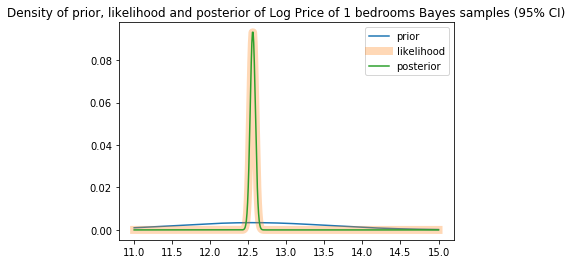

Mean = 12.559, Standard deviation = 0.475
The 0.950 credible interval is 12.495 to 12.627


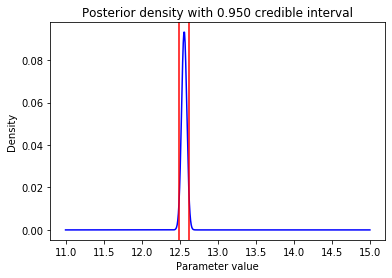



Mean = 12.794, Standard deviation = 0.454


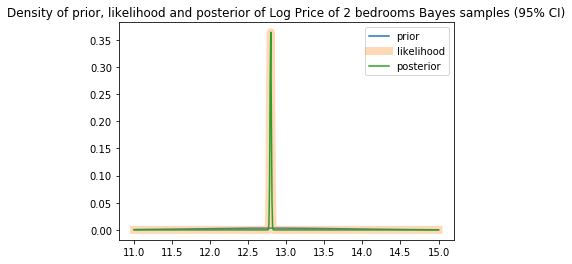

Mean = 12.794, Standard deviation = 0.454
The 0.950 credible interval is 12.780 to 12.812


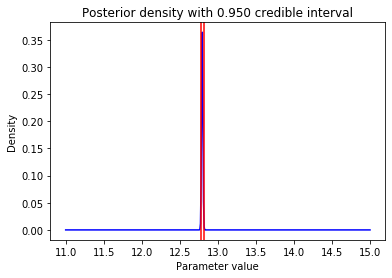



Mean = 12.925, Standard deviation = 0.455


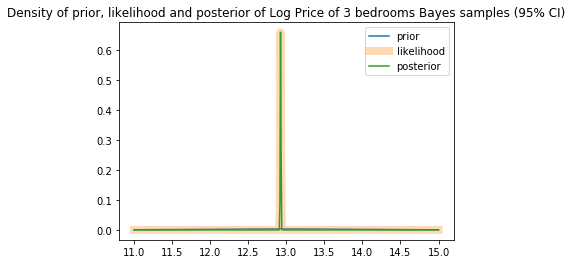

Mean = 12.925, Standard deviation = 0.455
The 0.950 credible interval is 12.916 to 12.932


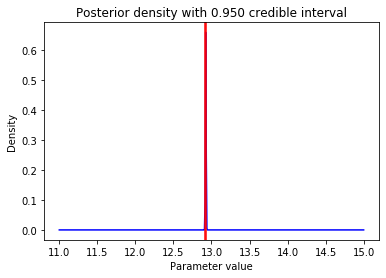



Mean = 13.195, Standard deviation = 0.481


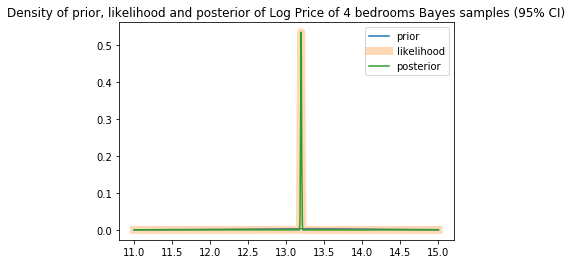

Mean = 13.195, Standard deviation = 0.481
The 0.950 credible interval is 13.180 to 13.204


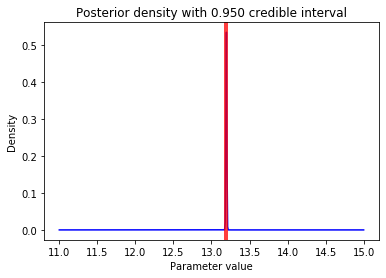



Mean = 13.331, Standard deviation = 0.508


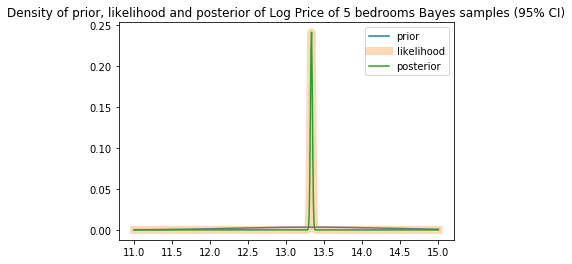

Mean = 13.331, Standard deviation = 0.508
The 0.950 credible interval is 13.309 to 13.357


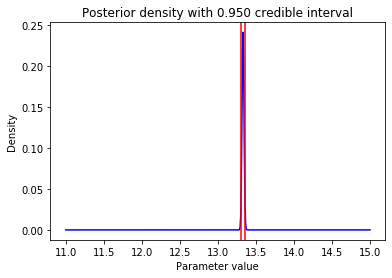



Mean = 13.323, Standard deviation = 0.498


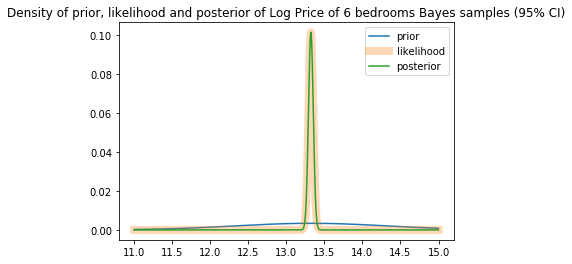

Mean = 13.323, Standard deviation = 0.498
The 0.950 credible interval is 13.261 to 13.381


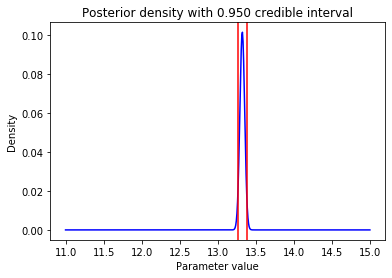



Bayesian statistics for Bedrooms


,1bd,2bd,3bd,4bd,5bd,6bd
mean,12.56,12.79,12.93,13.2,13.33,13.32
ci_lower,12.49,12.78,12.92,13.18,13.31,13.26
ci_upper,12.63,12.81,12.93,13.2,13.36,13.38


In [19]:
#bayes sample & summary statistics of log price by bedrooms

N = 500
p =  np.linspace(11, 15, num=N)

lower_q = 2.5/100
upper_q = 97.5/100

idx3 = ['pp', 'like', 'post', 'mean', 'ci_lower', 'ci_upper']

bd_bayes = pd.DataFrame(columns = bd, index = idx3)

for a in bd:
    bd_bayes.loc['pp'][a] = ss.norm.pdf(p, loc=df2[df2['bedrooms']==int(a[0])]['log_price'].mean()) / (ss.norm.pdf(p, loc=df2[df2['bedrooms']==int(a[0])]['log_price'].mean())).sum()
    bd_bayes.loc['like'][a] = comp_like(p, df2[df2['bedrooms']==int(a[0])]['log_price'])[0]
    bd_bayes.loc['post'][a] = posterior(bd_bayes.loc['pp'][a], bd_bayes.loc['like'][a])

    plt.plot(p, bd_bayes.loc['pp'][a], label='prior')
    plt.plot(p, bd_bayes.loc['like'][a], label='likelihood', alpha=.3, linewidth=8)
    plt.plot(p, bd_bayes.loc['post'][a], label='posterior')
    _=plt.legend()
    plt.title('Density of prior, likelihood and posterior of Log Price of ' + a[0:1] + ' bedrooms Bayes samples (95% CI)')
    plt.show()
    
    bd_bayes.loc['mean'][a] = round(comp_like(p, df2[df2['bedrooms']==int(a[0])]['log_price'])[1],2)
    bd_bayes.loc['ci_lower'][a], bd_bayes.loc['ci_upper'][a] = plot_ci(p, bd_bayes.loc['post'][a], N, lower_q, upper_q)
    plt.show()
    print('\n')

print('Bayesian statistics for Bedrooms')
bd_bayes.loc[['mean', 'ci_lower', 'ci_upper']]

Mean = 12.081, Standard deviation = 0.606


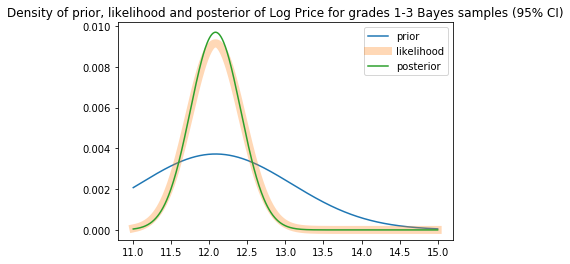

Mean = 12.081, Standard deviation = 0.606
The 0.950 credible interval is 11.377 to 12.723


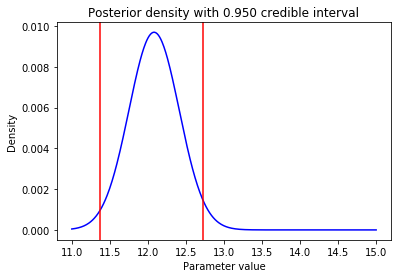



Mean = 12.513, Standard deviation = 0.399


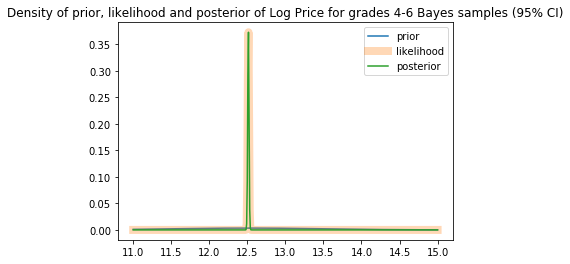

Mean = 12.513, Standard deviation = 0.399
The 0.950 credible interval is 12.499 to 12.531


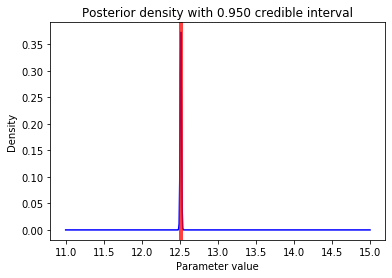



Mean = 13.030, Standard deviation = 0.433


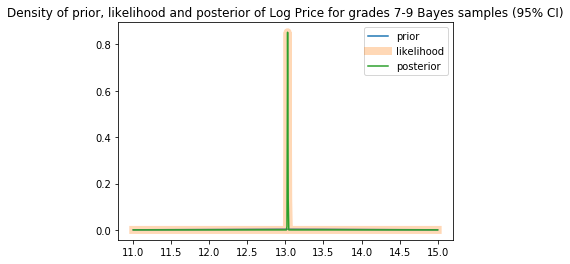

Mean = 13.030, Standard deviation = 0.433
The 0.950 credible interval is 13.028 to 13.036


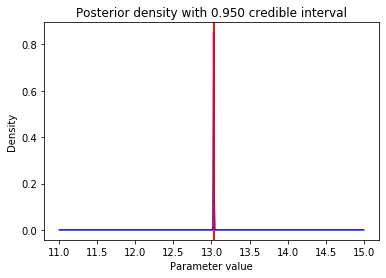



Mean = 13.822, Standard deviation = 0.341


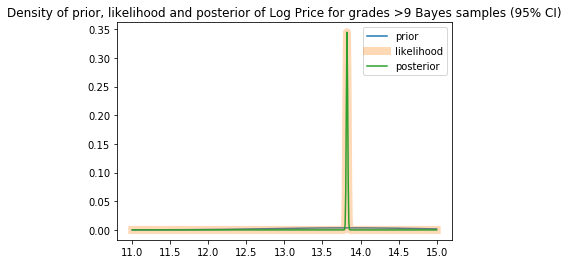

Mean = 13.822, Standard deviation = 0.341
The 0.950 credible interval is 13.806 to 13.838


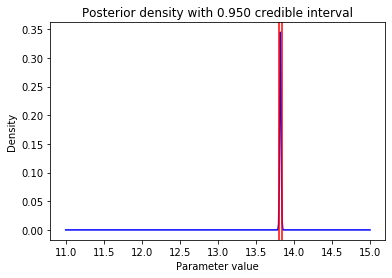



Bayesian statistics for Grade


,1-3,4-6,7-9,>9
mean,12.08,12.51,13.03,13.82
ci_lower,11.38,12.5,13.03,13.81
ci_upper,12.72,12.53,13.04,13.84


In [20]:
#bayes sample & summary statistics of log price by grade_bin

grd_bayes = pd.DataFrame(columns = grd_bin, index = idx3)

for a in grd_bin:
    grd_bayes.loc['pp'][a] = ss.norm.pdf(p, loc=df2[df2['grade_bin']==a]['log_price'].mean()) / (ss.norm.pdf(p, loc=df2[df2['grade_bin']==a]['log_price'].mean())).sum()
    grd_bayes.loc['like'][a] = comp_like(p, df2[df2['grade_bin']==a]['log_price'])[0]
    grd_bayes.loc['post'][a] = posterior(grd_bayes.loc['pp'][a], grd_bayes.loc['like'][a])

    plt.plot(p, grd_bayes.loc['pp'][a], label='prior')
    plt.plot(p, grd_bayes.loc['like'][a], label='likelihood', alpha=.3, linewidth=8)
    plt.plot(p, grd_bayes.loc['post'][a], label='posterior')
    _=plt.legend()
    plt.title('Density of prior, likelihood and posterior of Log Price for grades ' + a + ' Bayes samples (95% CI)')
    plt.show()
    
    grd_bayes.loc['mean'][a] = round(comp_like(p, df2[df2['grade_bin']==a]['log_price'])[1],2)
    grd_bayes.loc['ci_lower'][a], grd_bayes.loc['ci_upper'][a] = plot_ci(p, grd_bayes.loc['post'][a], N, lower_q, upper_q)
    plt.show()
    print('\n')

print('Bayesian statistics for Grade')
grd_bayes.loc[['mean', 'ci_lower', 'ci_upper']]

Mean = 13.167, Standard deviation = 0.452


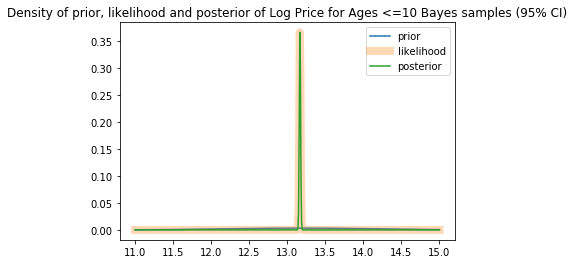

Mean = 13.167, Standard deviation = 0.452
The 0.950 credible interval is 13.148 to 13.180


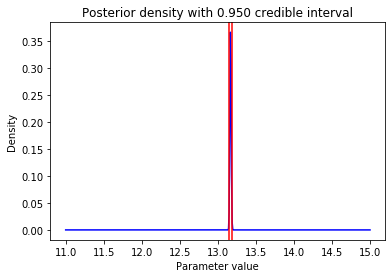



Mean = 13.149, Standard deviation = 0.454


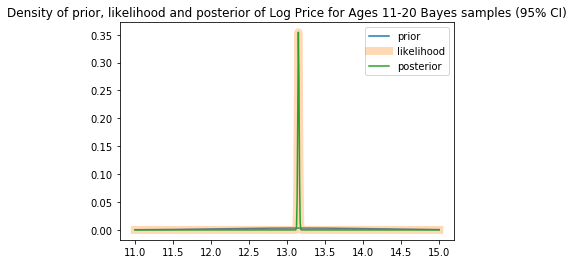

Mean = 13.149, Standard deviation = 0.454
The 0.950 credible interval is 13.132 to 13.164


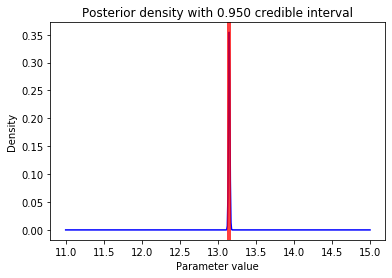



Mean = 13.045, Standard deviation = 0.483


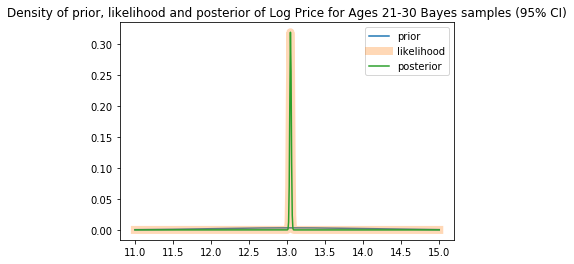

Mean = 13.045, Standard deviation = 0.483
The 0.950 credible interval is 13.028 to 13.060


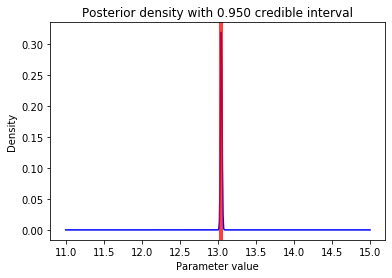



Mean = 12.980, Standard deviation = 0.464


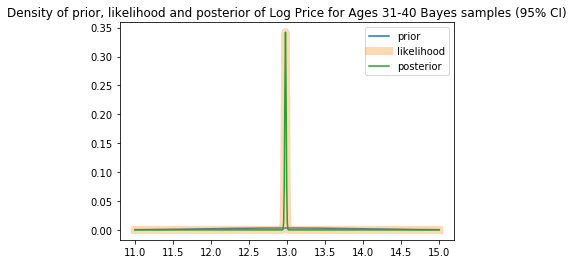

Mean = 12.980, Standard deviation = 0.464
The 0.950 credible interval is 12.964 to 12.996


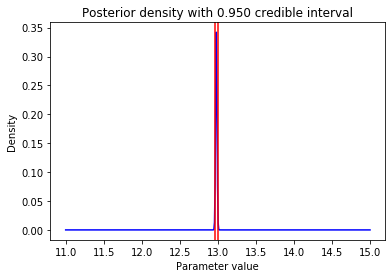



Mean = 12.896, Standard deviation = 0.505


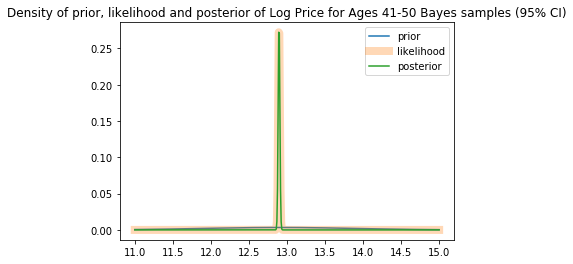

Mean = 12.896, Standard deviation = 0.505
The 0.950 credible interval is 12.876 to 12.916


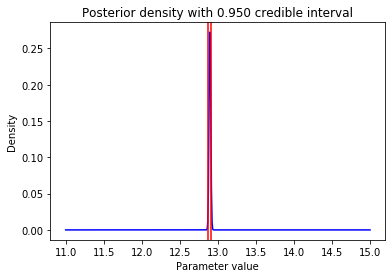



Mean = 12.894, Standard deviation = 0.501


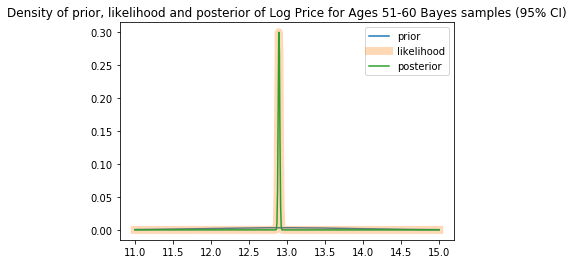

Mean = 12.894, Standard deviation = 0.501
The 0.950 credible interval is 12.876 to 12.916


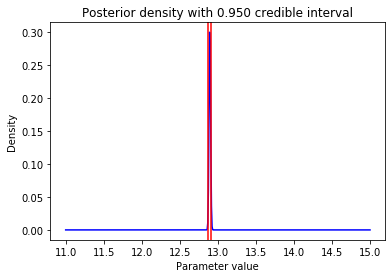



Mean = 12.924, Standard deviation = 0.516


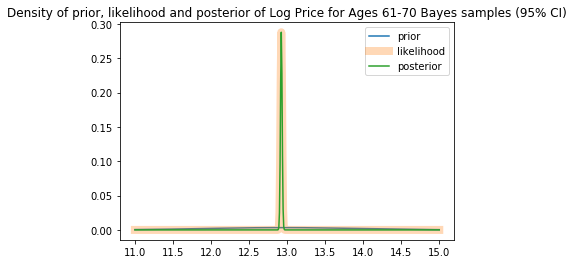

Mean = 12.924, Standard deviation = 0.516
The 0.950 credible interval is 12.900 to 12.940


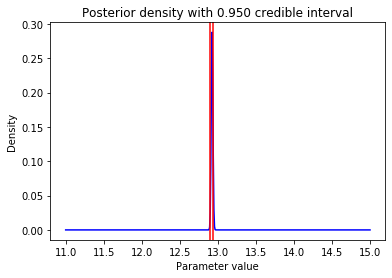



Mean = 12.863, Standard deviation = 0.538


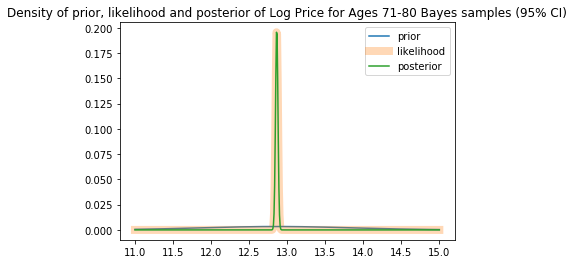

Mean = 12.863, Standard deviation = 0.538
The 0.950 credible interval is 12.836 to 12.892


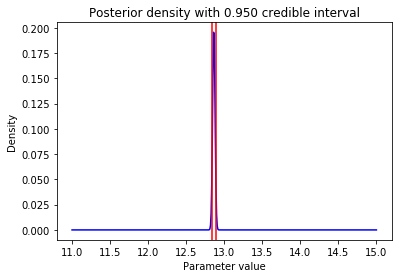



Mean = 13.134, Standard deviation = 0.503


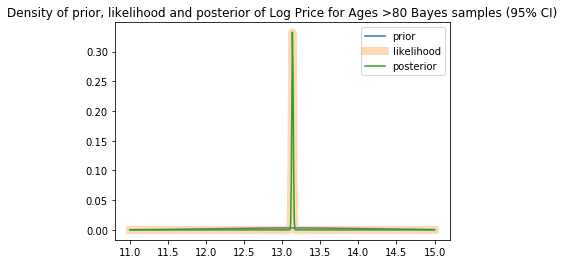

Mean = 13.134, Standard deviation = 0.503
The 0.950 credible interval is 13.116 to 13.148


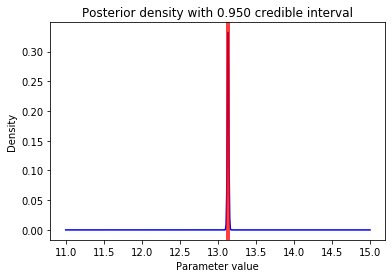



Bayesian statistics for Age


,<=10,11-20,21-30,31-40,41-50,51-60,61-70,71-80,>80
mean,13.17,13.15,13.05,12.98,12.9,12.89,12.92,12.86,13.13
ci_lower,13.15,13.13,13.03,12.96,12.88,12.88,12.9,12.84,13.12
ci_upper,13.18,13.16,13.06,13,12.92,12.92,12.94,12.89,13.15


In [21]:
#bayes sample & summary statistics of log price by age_bin

age_bayes = pd.DataFrame(columns = age_bin, index = idx3)

for a in age_bin:
    age_bayes.loc['pp'][a] = ss.norm.pdf(p, loc=df2[df2['age_bin']==a]['log_price'].mean()) / (ss.norm.pdf(p, loc=df2[df2['age_bin']==a]['log_price'].mean())).sum()
    age_bayes.loc['like'][a] = comp_like(p, df2[df2['age_bin']==a]['log_price'])[0]
    age_bayes.loc['post'][a] = posterior(age_bayes.loc['pp'][a], age_bayes.loc['like'][a])

    plt.plot(p, age_bayes.loc['pp'][a], label='prior')
    plt.plot(p, age_bayes.loc['like'][a], label='likelihood', alpha=.3, linewidth=8)
    plt.plot(p, age_bayes.loc['post'][a], label='posterior')
    _=plt.legend()
    plt.title('Density of prior, likelihood and posterior of Log Price for Ages ' + a + ' Bayes samples (95% CI)')
    plt.show()
    
    age_bayes.loc['mean'][a] = round(comp_like(p, df2[df2['age_bin']==a]['log_price'])[1],2)
    age_bayes.loc['ci_lower'][a], age_bayes.loc['ci_upper'][a] = plot_ci(p, age_bayes.loc['post'][a], N, lower_q, upper_q)
    plt.show()
    print('\n')

print('Bayesian statistics for Age')
age_bayes.loc[['mean', 'ci_lower', 'ci_upper']]

In [22]:
#bedrooms statistics: classic, botostrap & bayesian

print('Classical Summary Statistics for Log Price by Bedrooms - 95% CI')
print(bd_sum_stats)

print('\nBootstrap Summary Statistics for Log Price by Bedrooms - 95% CI')
print(bd_sum_stats_boot)

print('\nBayesian Summary Statistics for Log Price by Bedrooms - 95% CI')
print(bd_bayes.loc[['mean', 'ci_lower', 'ci_upper']])

Classical Summary Statistics for Log Price by Bedrooms - 95% CI
            1bd    2bd    3bd    4bd    5bd    6bd
mean      12.56  12.79  12.93   13.2  13.33  13.32
std_err    0.03   0.01      0   0.01   0.01   0.03
ci_lower   12.5  12.77  12.93  13.18  13.31  13.26
ci_upper  12.62  12.81  12.93  13.22  13.35  13.38

Bootstrap Summary Statistics for Log Price by Bedrooms - 95% CI
            1bd    2bd    3bd    4bd    5bd    6bd
mean      12.56  12.79  12.93   13.2  13.33  13.32
ci_lower  12.49  12.78  12.92  13.18   13.3  13.26
ci_upper  12.63  12.81  12.93  13.21  13.36  13.38

Bayesian Summary Statistics for Log Price by Bedrooms - 95% CI
            1bd    2bd    3bd    4bd    5bd    6bd
mean      12.56  12.79  12.93   13.2  13.33  13.32
ci_lower  12.49  12.78  12.92  13.18  13.31  13.26
ci_upper  12.63  12.81  12.93   13.2  13.36  13.38


In [23]:
print('Classical Summary Statistics for Log Price by Grade - 95% CI')
print(grd_sum_stats)

print('\nBootstrap Summary Statistics for Log Price by Grade - 95% CI')
print(grd_sum_stats_boot)

print('\nBayesian Summary Statistics for Log Price by Grade - 95% CI')
print(grd_bayes.loc[['mean', 'ci_lower', 'ci_upper']])

Classical Summary Statistics for Log Price by Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.08  12.51  13.03  13.82
std_err    0.43   0.01      0   0.01
ci_lower  11.24  12.49  13.03   13.8
ci_upper  12.92  12.53  13.03  13.84

Bootstrap Summary Statistics for Log Price by Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.08  12.51  13.03  13.82
ci_lower    NaN   12.5  13.02   13.8
ci_upper  12.54  12.53  13.04  13.84

Bayesian Summary Statistics for Log Price by Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.08  12.51  13.03  13.82
ci_lower  11.38   12.5  13.03  13.81
ci_upper  12.72  12.53  13.04  13.84


In [24]:
print('Classical Summary Statistics for Log Price by Age - 95% CI')
print(age_sum_stats)

print('\nBootstrap Summary Statistics for Log Price by Age - 95% CI')
print(age_sum_stats_boot)

print('\nBayesian Summary Statistics for Log Price by Age - 95% CI')
print(age_bayes.loc[['mean', 'ci_lower', 'ci_upper']])

Classical Summary Statistics for Log Price by Age - 95% CI
           <=10  11-20  21-30  31-40  41-50  51-60  61-70  71-80    >80
mean      13.17  13.15  13.05  12.98   12.9  12.89  12.92  12.86  13.13
std_err    0.01   0.01   0.01   0.01   0.01   0.01   0.01   0.02   0.01
ci_lower  13.15  13.13  13.03  12.96  12.88  12.87   12.9  12.82  13.11
ci_upper  13.19  13.17  13.07     13  12.92  12.91  12.94   12.9  13.15

Bootstrap Summary Statistics for Log Price by Age - 95% CI
           <=10  11-20  21-30  31-40  41-50  51-60  61-70  71-80    >80
mean      13.17  13.15  13.04  12.98   12.9  12.89  12.92  12.86  13.13
ci_lower  13.15  13.13  13.02  12.96  12.88  12.87   12.9  12.83  13.12
ci_upper  13.18  13.17  13.06     13  12.92  12.92  12.95   12.9  13.15

Bayesian Summary Statistics for Log Price by Age - 95% CI
           <=10  11-20  21-30  31-40  41-50  51-60  61-70  71-80    >80
mean      13.17  13.15  13.05  12.98   12.9  12.89  12.92  12.86  13.13
ci_lower  13.15  13.13  13.03 

#### Leverage confidence intervals in performing hypothesis tests to determina if the differences in pairs and multiple populations are significant

#### Hypothesis Testing

In [25]:
#t-test

def t_test(a, b, alpha, alternative='two-sided', usevar = 'unequal'):
    diff = a.mean() - b.mean()

    t, p, df = ws.ttest_ind(a, b, usevar=usevar)
    
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha=alpha, alternative=alternative, usevar=usevar) 

    index = ['DegFreedom', 'Difference', 'Statistic', 'PValue', 'Low95CI', 'High95CI']
    return pd.Series([df, diff, t, p, confint[0], confint[1]], index = index)


def hist_plot(vec, bins):
    plt.hist(vec, bins = bins)
    plt.axvline(np.mean(vec), color = 'red')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

    
def plot_pop(a, b, cols=['pop_A', 'pop_B'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_plot(a, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)
    

def hist_mean_ci(vec, t_test, bins):
    upper = np.mean(vec) + t_test[5] - t_test[1]
    lower = np.mean(vec) + t_test[4] - t_test[1]
    plt.hist(vec, bins = bins)
    plt.axvline(np.mean(vec), color = 'red')
    plt.axvline(upper, color = 'red', linestyle='--')
    plt.axvline(lower, color = 'red', linestyle='--')
    plt.ylabel('Frequency')
    plt.xlabel('Value')

    
def plot_t(a, b, t_test, cols=['pop_A', 'pop_B'], nbins = 20):
    minx = min([min(a), min(b)])
    maxx = max([max(a), max(b)])
    stepx = (maxx - minx)/(nbins + 1)
    bins = [minx + i * stepx for i in range(nbins + 1)]
    plt.subplot(2, 1, 1) # The first plot
    hist_mean_ci(a, t_test, bins)
    plt.title('Histograme of ' + cols[0] + ' and ' + cols[1])
    plt.subplot(2, 1, 2) # The next plot
    hist_plot(b, bins)

__T-Test on Mean Log Price of Houses with Basement__

H_null = Houses with basement are NOT more expensive than houses with no basement

T-Test results
DegFreedom     1.788788e+04
Difference     2.121396e-01
Statistic      3.085475e+01
PValue        1.021751e-203
Low95CI        1.986631e-01
High95CI       2.256161e-01
dtype: float64

pop_A = Log price of house with no basement
pop_B = Log price of house with basement


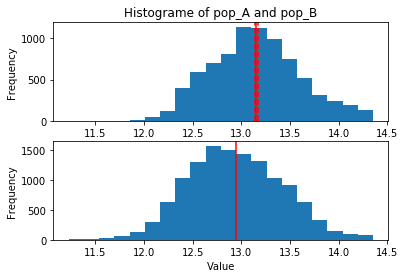

In [26]:
#Are houses with basement are more expensive than houses with no basement?

nobasement_price = df[(df['basement']==0)]['log_price']
basement_price = df[(df['basement']==1)]['log_price']

#t-test 95% confidence interval
basement_test = t_test(nobasement_price, basement_price, 0.05)

print('T-Test results')
print(basement_test)

print('\npop_A = Log price of house with no basement')
print('pop_B = Log price of house with basement')
plot_t(nobasement_price, basement_price, basement_test)

Based on the t-test on basement above, we can reject the H_null (houses with basement are NOT more expensive than houses with no basement) because the p-value is small. We also see in the histogram that the means and 95% CIs for the two population do not overlap.

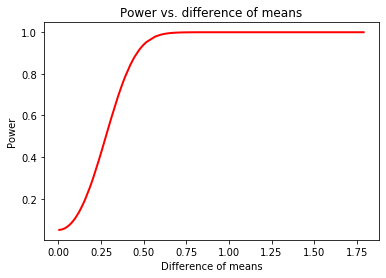

In [27]:
diffs = np.sort(np.absolute(df[(df['basement']==0)]['log_price'].sample(100).reset_index(drop=True) - df[(df['basement']==1)]['log_price'].sample(100).reset_index(drop=True)))
x = 100

powers = [smsp.tt_ind_solve_power(effect_size = x, nobs1 = 100, 
           alpha = 0.05, power = None, ratio = 1.0, alternative = 'two-sided') 
          for x in diffs]

def plot_power(x, y, xlabel, title):
    plt.plot(x, y, color = 'red', linewidth = 2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Power')
    
plot_power(diffs, powers, xlabel = 'Difference of means', title = 'Power vs. difference of means')    

__T-Test on Mean Log Price of Houses with Waterfront__

H_null = Houses with waterfront are NOT more expensive than houses with no waterfront


T-Test results
DegFreedom    1.141166e+02
Difference   -7.771095e-01
Statistic    -1.580527e+01
PValue        1.637915e-30
Low95CI      -8.745094e-01
High95CI     -6.797097e-01
dtype: float64

pop_A = Log price of non-waterfront house
pop_B = Log price of waterfront house


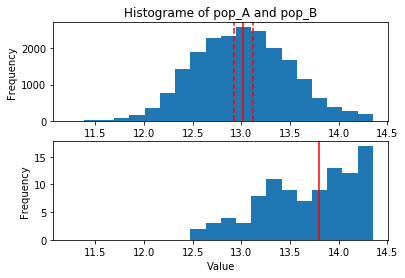

In [28]:
#Are houses with waterfront are more expensive than houses with no waterfront?

nowaterfront_price = df[(df['waterfront']==0)]['log_price']
waterfront_price = df[(df['waterfront']==1)]['log_price']

#t-test 95% confidence interval
waterfront_test = t_test(nowaterfront_price, waterfront_price, 0.05)

print('T-Test results')
print(waterfront_test)

print('\npop_A = Log price of non-waterfront house')
print('pop_B = Log price of waterfront house')
plot_t(nowaterfront_price, waterfront_price, waterfront_test)

Based on the t-test on basement above, we can reject the H_null (houses with waterfront are NOT more expensive than houses with no waterfront) because the p-value is small. We also see in the histogram that the means and 95% CIs for the two population do not overlap.

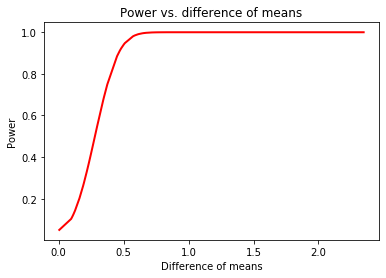

In [29]:
diffs = np.sort(np.absolute(df[(df['waterfront']==0)]['log_price'].sample(100).reset_index(drop=True) - df[(df['waterfront']==1)]['log_price'].sample(100).reset_index(drop=True)))
x = 100

powers = [smsp.tt_ind_solve_power(effect_size = x, nobs1 = 100, 
           alpha = 0.05, power = None, ratio = 1.0, alternative = 'two-sided') 
          for x in diffs]

def plot_power(x, y, xlabel, title):
    plt.plot(x, y, color = 'red', linewidth = 2)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel('Power')
    
plot_power(diffs, powers, xlabel = 'Difference of means', title = 'Power vs. difference of means')    

__Hypothesis test on mean log price of houses with different number of bedrooms__

H_null = The number of bedrooms does not affect the house price

In [30]:
#anova of log price based on bedrooms

f_statistic_bd, p_value_bd = ss.f_oneway(df[df['bedrooms']==1]['log_price'], df[df['bedrooms']==2]['log_price'],
                                         df[df['bedrooms']==3]['log_price'], df[df['bedrooms']==6]['log_price'], 
                                         df[df['bedrooms']==5]['log_price'], df[df['bedrooms']==1]['log_price'])

print('F statistic = ' + str(f_statistic_bd))
print('P-value = ' + str(p_value_bd))

F statistic = 358.7836543382068
P-value = 0.0


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj lower  upper  reject
-------------------------------------------------
   1.0    2.0   0.2353 0.001 0.1362 0.3345   True
   1.0    3.0    0.366 0.001 0.2693 0.4628   True
   1.0    4.0   0.6363 0.001 0.5391 0.7335   True
   1.0    5.0   0.7714 0.001 0.6697 0.8732   True
   1.0    6.0   0.7635 0.001 0.6359 0.8912   True
   2.0    3.0   0.1307 0.001 0.1017 0.1597   True
   2.0    4.0    0.401 0.001 0.3705 0.4314   True
   2.0    5.0   0.5361 0.001 0.4933 0.5789   True
   2.0    6.0   0.5282 0.001   0.44 0.6164   True
   3.0    4.0   0.2703 0.001  0.249 0.2916   True
   3.0    5.0   0.4054 0.001 0.3685 0.4423   True
   3.0    6.0   0.3975 0.001  0.312  0.483   True
   4.0    5.0   0.1352 0.001 0.0972 0.1732   True
   4.0    6.0   0.1273 0.001 0.0413 0.2132   True
   5.0    6.0  -0.0079   0.9 -0.099 0.0832  False
-------------------------------------------------


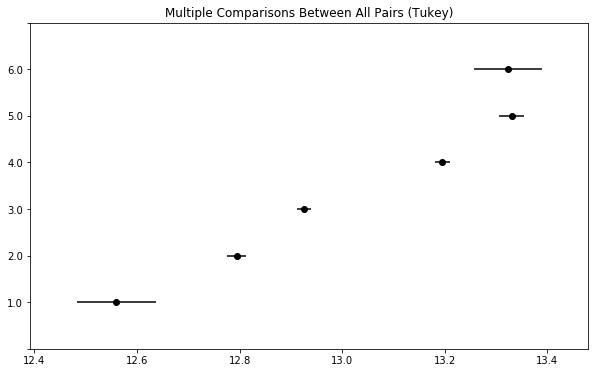

In [31]:
#tukey's hsd of log price based on bedrooms

Tukey_HSD = pairwise_tukeyhsd(df['log_price'], df['bedrooms'])
print(Tukey_HSD)

_ = Tukey_HSD.plot_simultaneous()

Based on our classical ANOVA test, we see that we can reject the H_null that house price does not depend on the number of bedrooms (small p-value, large F-statistic). Using Tukey's HSD, we see that the prices of houses with 1, 2, 3 and 4 bedrooms are significantly different from each other and from houses with 5 or 6 bedrooms. However prices for houses with 5 & 6 bedrooms are not significantly different from each other.

In [32]:
print('\nBootstrap summary statistics of Log Price on Bedrooms - 95% CI')
print(bd_sum_stats_boot)


Bootstrap summary statistics of Log Price on Bedrooms - 95% CI
            1bd    2bd    3bd    4bd    5bd    6bd
mean      12.56  12.79  12.93   13.2  13.33  13.32
ci_lower  12.49  12.78  12.92  13.18   13.3  13.26
ci_upper  12.63  12.81  12.93  13.21  13.36  13.38


Point estimate of the mean =  12.56
The lower and upper confidence intervals =  12.49  12.63


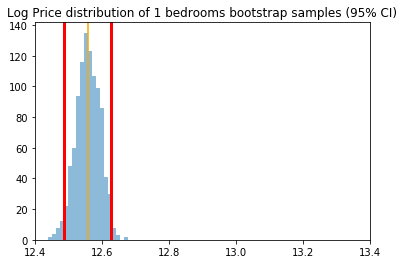



Point estimate of the mean =  12.79
The lower and upper confidence intervals =  12.78  12.81


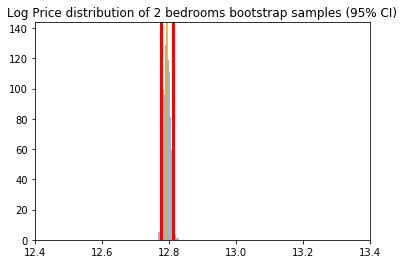



Point estimate of the mean =  12.93
The lower and upper confidence intervals =  12.92  12.93


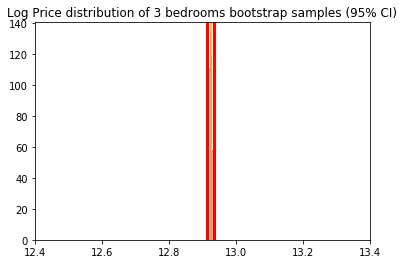



Point estimate of the mean =  13.20
The lower and upper confidence intervals =  13.18  13.21


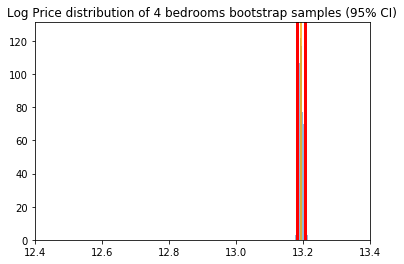



Point estimate of the mean =  13.33
The lower and upper confidence intervals =  13.30  13.36


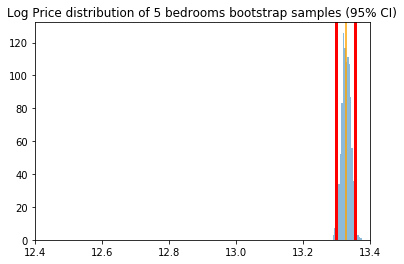



Point estimate of the mean =  13.32
The lower and upper confidence intervals =  13.26  13.38


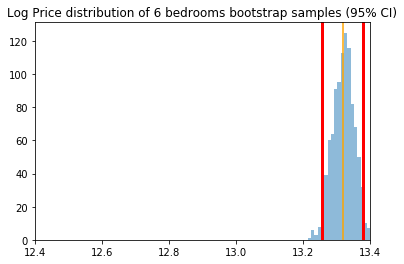

In [33]:
for j in bd:
    plot_hist(bd_sample_mean_boot[j], bd_sample_mean_boot[j].min(), bd_sample_mean_boot[j].max())
    plt.title('Log Price distribution of ' + j[0:1] + ' bedrooms bootstrap samples (95% CI)')
    plt.xlim(12.4,13.4)
    plt.show()
    print('\n')

Based on the Bootstrap summary statistics and charts above, we come to the same conclusion as our classical conclusion above.

We also used Bayesian method to predict if we observe significant difference in log price mean based on bedrooms. Based on our results below, we conclude that there is a significant difference in log price means between houses with 1-4 bedrooms. However houses with 5 and 6 bedrooms do not have significant difference in log price means.

In [34]:
print('Bayes statistics of Log Price based on Bedrooms - 95% CI')
print(bd_bayes.loc[['mean', 'ci_lower', 'ci_upper']],'\n')

Bayes statistics of Log Price based on Bedrooms - 95% CI
            1bd    2bd    3bd    4bd    5bd    6bd
mean      12.56  12.79  12.93   13.2  13.33  13.32
ci_lower  12.49  12.78  12.92  13.18  13.31  13.26
ci_upper  12.63  12.81  12.93   13.2  13.36  13.38 



__Hypothesis test on mean log price of houses in different grade bins__

H_null = The grade of a house does not affect the house price

In [35]:
#anova of log price based on grade bin

f_statistic_grd, p_value_grd = ss.f_oneway(df[df['grade_bin']=='1-3']['log_price'], df[df['grade_bin']=='4-6']['log_price'],
                                         df[df['grade_bin']=='7-9']['log_price'], df[df['grade_bin']=='>9']['log_price'])

print('F statistic = ' + str(f_statistic_grd))
print('P-value = ' + str(p_value_grd))

F statistic = 2710.090056309925
P-value = 0.0


Multiple Comparison of Means - Tukey HSD, FWER=0.05
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
   1-3    4-6   0.4318 0.2915 -0.1974 1.0611  False
   1-3    7-9   0.9483  0.001  0.3193 1.5772   True
   1-3     >9    1.741  0.001  1.1115 2.3706   True
   4-6    7-9   0.5164  0.001  0.4921 0.5407   True
   4-6     >9   1.3092  0.001  1.2718 1.3465   True
   7-9     >9   0.7928  0.001  0.7621 0.8235   True
---------------------------------------------------


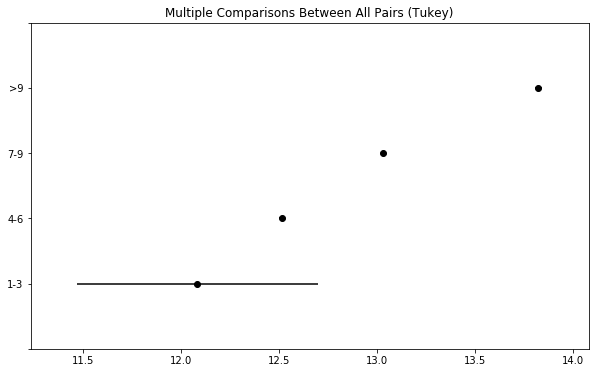

In [36]:
#tukey's hsd of log price based on grade bin

Tukey_HSD = pairwise_tukeyhsd(df['log_price'], df['grade_bin'])
print(Tukey_HSD)

_ = Tukey_HSD.plot_simultaneous()

Based on our classical ANOVA test, we see that we can reject the H_null that house price does not depend on the grade of the house (small p-value, large F-statistic). Using Tukey's HSD, we see that the prices of houses with grades 1-3 and 4-6 are not significantly different. However prices for houses with other grades are  significantly different from each other.

In [37]:
print('\nBootstrap summary statistics of Log Price on Grade Bin - 95% CI')
print(grd_sum_stats_boot)


Bootstrap summary statistics of Log Price on Grade Bin - 95% CI
            1-3    4-6    7-9     >9
mean      12.08  12.51  13.03  13.82
ci_lower    NaN   12.5  13.02   13.8
ci_upper  12.54  12.53  13.04  13.84


Point estimate of the mean =  12.08
The lower and upper confidence intervals =    nan  12.54


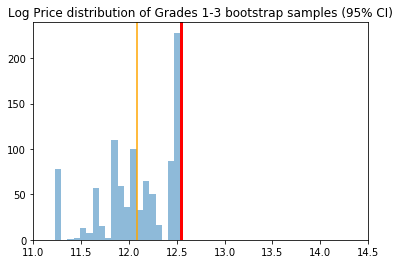



Point estimate of the mean =  12.51
The lower and upper confidence intervals =  12.50  12.53


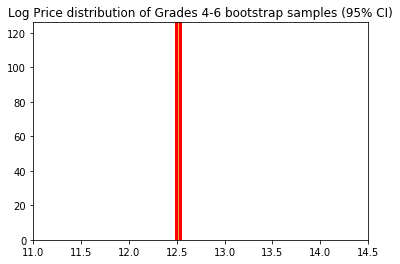



Point estimate of the mean =  13.03
The lower and upper confidence intervals =  13.02  13.04


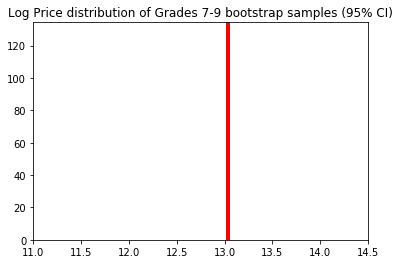



Point estimate of the mean =  13.82
The lower and upper confidence intervals =  13.80  13.84


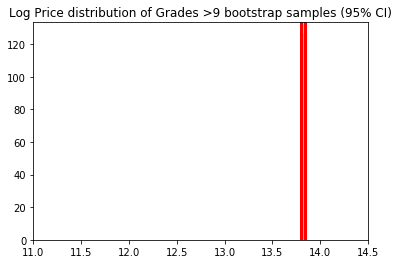

In [38]:
for j in grd_bin:
    plot_hist(grd_sample_mean_boot[j], grd_sample_mean_boot[j].min(), grd_sample_mean_boot[j].max())
    plt.title('Log Price distribution of Grades ' + j + ' bootstrap samples (95% CI)')
    plt.xlim(11,14.5)
    plt.show()
    print('\n')

Based on the Bootstrap summary statistics and charts above, we come to the same conclusion as our classical conclusion above.

We also try using Bayesian method to predict if we observe significant difference in log price mean based on grade. Based on our results below, we conclude that there is a significant difference in log price means between houses with different grades except between houses with grades 1-3 and 4-6.

In [39]:
print('Bayes statistics of Log Price based on Grade - 95% CI')
print(grd_bayes.loc[['mean', 'ci_lower', 'ci_upper']],'\n')

Bayes statistics of Log Price based on Grade - 95% CI
            1-3    4-6    7-9     >9
mean      12.08  12.51  13.03  13.82
ci_lower  11.38   12.5  13.03  13.81
ci_upper  12.72  12.53  13.04  13.84 



__Hypothesis test on mean log price of houses in different grade bins__

H_null = The age of a house does not affect the house price

In [40]:
#anova of log price based on age bin

f_statistic_age, p_value_age = ss.f_oneway(df[df['age_bin']=='<=10']['log_price'], df[df['age_bin']=='11-20']['log_price'],
                                         df[df['age_bin']=='21-30']['log_price'], df[df['age_bin']=='31-40']['log_price'],
                                         df[df['age_bin']=='41-50']['log_price'], df[df['age_bin']=='51-60']['log_price'],
                                         df[df['age_bin']=='61-70']['log_price'], df[df['age_bin']=='71-80']['log_price'],
                                         df[df['age_bin']=='>80']['log_price'])

print('F statistic = ' + str(f_statistic_age))
print('P-value = ' + str(p_value_age))

F statistic = 139.6690862460372
P-value = 1.0922886646276598e-229


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
 11-20  21-30   -0.104  0.001 -0.1471 -0.0609   True
 11-20  31-40  -0.1695  0.001 -0.2121  -0.127   True
 11-20  41-50  -0.2536  0.001 -0.2981 -0.2092   True
 11-20  51-60  -0.2549  0.001  -0.298 -0.2118   True
 11-20  61-70  -0.2251  0.001 -0.2692 -0.1809   True
 11-20  71-80  -0.2859  0.001 -0.3397 -0.2322   True
 11-20   <=10   0.0174    0.9 -0.0234  0.0582  False
 11-20    >80  -0.0156    0.9 -0.0569  0.0257  False
 21-30  31-40  -0.0655  0.001 -0.1091  -0.022   True
 21-30  41-50  -0.1497  0.001  -0.195 -0.1043   True
 21-30  51-60  -0.1509  0.001 -0.1949 -0.1069   True
 21-30  61-70  -0.1211  0.001 -0.1661  -0.076   True
 21-30  71-80  -0.1819  0.001 -0.2364 -0.1274   True
 21-30   <=10   0.1214  0.001  0.0796  0.1632   True
 21-30    >80   0.0884  0.001  0.0462  0.1307   True
 31-40  41-50  -0.0841  0.001  -0.129 -0.0392 

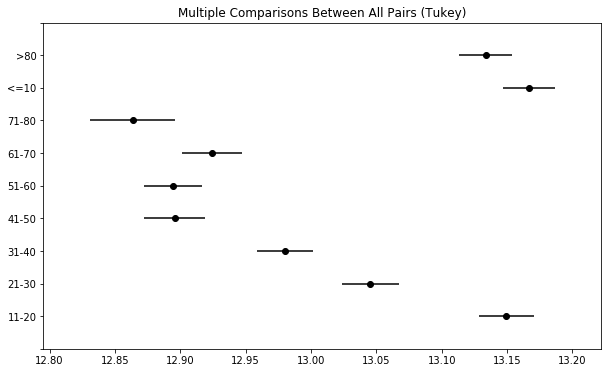

In [41]:
#tukey's hsd of log price based on age bin

Tukey_HSD = pairwise_tukeyhsd(df['log_price'], df['age_bin'])
print(Tukey_HSD)

_ = Tukey_HSD.plot_simultaneous()

Based on our classical ANOVA test, we see that we can reject the H_null that house price does not depend on the age of the house (small p-value, large F-statistic). Using Tukey's HSD, we see that the mean log price of houses with ages <=10, 11-20 and >80 is not significantly different from each other. We also observe that houses 41-50, 51-60, 61-70 and 71-80 years old do not have significant difference in mean log price from each other. However prices for houses with ages 21-30 and 31-40 are significantly different from each other and from other groups.

In [42]:
print('\nBootstrap summary statistics of Log Price on Age Bin - 95% CI')
print(age_sum_stats_boot)


Bootstrap summary statistics of Log Price on Age Bin - 95% CI
           <=10  11-20  21-30  31-40  41-50  51-60  61-70  71-80    >80
mean      13.17  13.15  13.04  12.98   12.9  12.89  12.92  12.86  13.13
ci_lower  13.15  13.13  13.02  12.96  12.88  12.87   12.9  12.83  13.12
ci_upper  13.18  13.17  13.06     13  12.92  12.92  12.95   12.9  13.15


Point estimate of the mean =  13.17
The lower and upper confidence intervals =  13.15  13.18


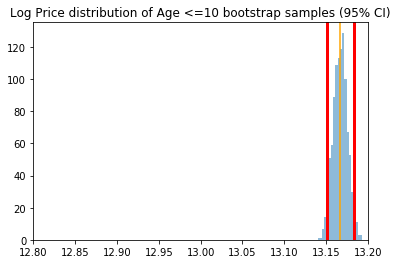



Point estimate of the mean =  13.15
The lower and upper confidence intervals =  13.13  13.17


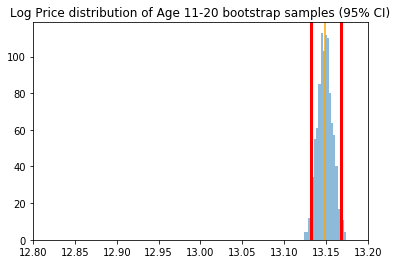



Point estimate of the mean =  13.04
The lower and upper confidence intervals =  13.02  13.06


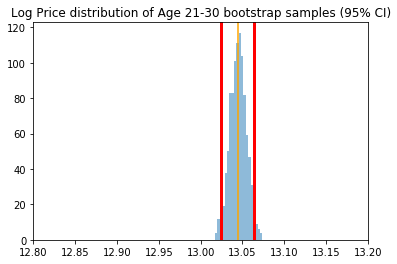



Point estimate of the mean =  12.98
The lower and upper confidence intervals =  12.96  13.00


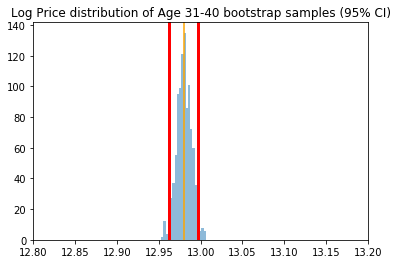



Point estimate of the mean =  12.90
The lower and upper confidence intervals =  12.88  12.92


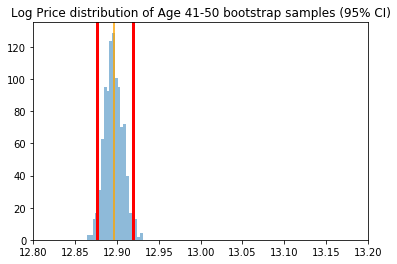



Point estimate of the mean =  12.89
The lower and upper confidence intervals =  12.87  12.92


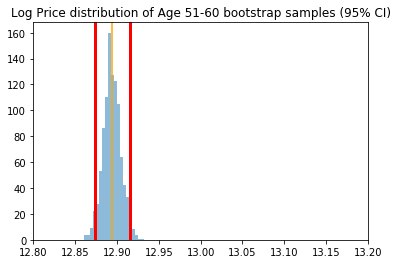



Point estimate of the mean =  12.92
The lower and upper confidence intervals =  12.90  12.95


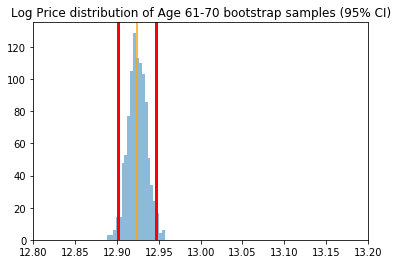



Point estimate of the mean =  12.86
The lower and upper confidence intervals =  12.83  12.90


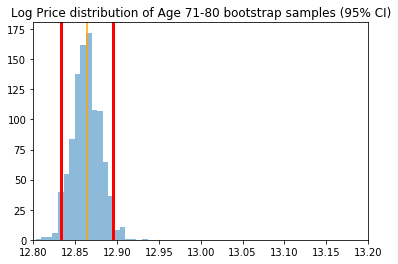



Point estimate of the mean =  13.13
The lower and upper confidence intervals =  13.12  13.15


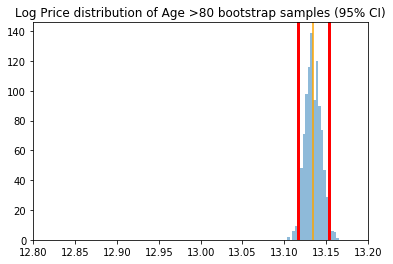

In [43]:
for j in age_bin:
    plot_hist(age_sample_mean_boot[j], age_sample_mean_boot[j].min(), age_sample_mean_boot[j].max())
    plt.title('Log Price distribution of Age ' + j + ' bootstrap samples (95% CI)')
    plt.xlim(12.8,13.2)
    plt.show()
    print('\n')

Based on the Bootstrap summary statistics and charts above, we come to the same conclusion as our classical conclusion above.

We also try using Bayesian method to predict if we observe significant difference in log price mean based on age. Based on our results below, we observe the same findings as the classical & bootstrap methods

In [44]:
print('\nBayes statistics of Log Price based on Age Bin - 95% CI')
print(age_bayes.loc[['mean', 'ci_lower', 'ci_upper']],'\n')


Bayes statistics of Log Price based on Age Bin - 95% CI
           <=10  11-20  21-30  31-40  41-50  51-60  61-70  71-80    >80
mean      13.17  13.15  13.05  12.98   12.9  12.89  12.92  12.86  13.13
ci_lower  13.15  13.13  13.03  12.96  12.88  12.88   12.9  12.84  13.12
ci_upper  13.18  13.16  13.06     13  12.92  12.92  12.94  12.89  13.15 

